In [3]:
from IPython.display import Image
from IPython.core.display import HTML
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
#hyperparameters

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [6]:
#Step 1 : Collect data
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p = [0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0
    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))
    
    return(x, y)
data = generateData()

print(data)

(array([[1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 0]]), array([[0, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 0, 0]]))


In [7]:
#Step 2: Build the model
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [9]:
#3 layer Recurrent net, one hidden state
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype= tf.float32)
b = tf.Variable(np.zeros((1, state_size)), dtype = tf.float32)
W2 = tf.Variable(np.random.rand(state_size, num_classes), dtype = tf.float32)
b2 = tf.Variable(np.zeros((1, num_classes)), dtype = tf.float32)

In [12]:
inputs_series = tf.unstack(batchX_placeholder, axis = 1)
labels_series = tf.unstack(batchY_placeholder, axis = 1)

In [13]:
tf.__version__

'1.1.0'

In [17]:
#Forward pass
current_state = init_state
states_series = []

for current_input in inputs_series:
    current_input = tf.reshape(current_input,[batch_size,1])
    input_and_state_concatenated = tf.concat([current_input, current_state],1)
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)
    
    states_series.append(next_state)
    current_state = next_state

In [21]:
#calculate loss
logits_series = [tf.matmul(state, W2)+ b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits,labels in zip(logits_series, labels_series)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [33]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

New data, epoch 0
Step 0 Loss 0.75877
Step 100 Loss 0.692337
Step 200 Loss 0.693215
Step 300 Loss 0.69792
Step 400 Loss 0.566788
Step 500 Loss 0.0969468
Step 600 Loss 0.0261796
New data, epoch 1
Step 0 Loss 0.241259
Step 100 Loss 0.00815951
Step 200 Loss 0.00668849
Step 300 Loss 0.00547115
Step 400 Loss 0.00390718
Step 500 Loss 0.0040989
Step 600 Loss 0.0026295
New data, epoch 2
Step 0 Loss 0.289145
Step 100 Loss 0.00185737
Step 200 Loss 0.00178356
Step 300 Loss 0.00141585
Step 400 Loss 0.00132807
Step 500 Loss 0.00215413
Step 600 Loss 0.00120205
New data, epoch 3
Step 0 Loss 0.388389
Step 100 Loss 0.00161154
Step 200 Loss 0.00108391
Step 300 Loss 0.00100081
Step 400 Loss 0.000956734
Step 500 Loss 0.000995122
Step 600 Loss 0.000952454
New data, epoch 4
Step 0 Loss 0.255806
Step 100 Loss 0.000858167
Step 200 Loss 0.000623614
Step 300 Loss 0.000831922
Step 400 Loss 0.000698387
Step 500 Loss 0.00076486
Step 600 Loss 0.000759198
New data, epoch 5
Step 0 Loss 0.299359
Step 100 Loss 0.000994

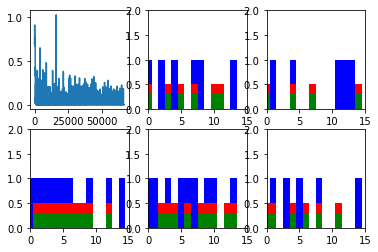

In [35]:
#step 3: training the network
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []
    for epoch_idx in range(num_epochs):
        x, y = generateData()
        _current_state = np.zeros((batch_size, state_size))
        print("New data, epoch", epoch_idx)
        for batch_idx in range(num_batches):
            start_idx  = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:, start_idx:end_idx]
            batchY = y[:, start_idx:end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series], 
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })
            loss_list.append(_total_loss)
            
            if batch_idx%100 ==0:
                print("Step", batch_idx, "Loss", _total_loss)
                #plot(loss_list, _predictions_series, batchX, batchY)
                plot(loss_list, _predictions_series, batchX, batchY)
                
plt.ioff()
plt.show()